# After meeting our players is time to understand if thay are replacable
#### Part 1: Simple modules sklearn
Here we will build simple classification moduls based on the allgames_stats dataset

* Step 1: we will build new module for each player
    * We will try several algorithems foreach player
    * We will compare the confusion matrix for each algorithem 
* Step 2: we will test each player's dataset agains the other players module
* Step 3: we will detamine who is the least replacable player

#### Part 2: Advance classifiers
* same test above using several Deep learning algorithms:
    * Simple NN
    * CNN 1D
    * RNN using LSTM based on game date 
    
    
#### Preparing dataset - requerments
As told before we will base on allgames_stats dataset
* Result - this will be our classification parameter 
    * W = 1 (win)
    * L = 0 (loose)
* Opp column should be related as dummies (each opponent team should be translated to its own column)
* MP should be converted to int
* RSorPO 
    * RS - regular series = 1
    * PO - playoff = 2
* parameters to drop:
    * Tm - players team is not relevant since we will relay on the personal skills of the player
    * X - not relevant column
    * GS - not relevant column 
    * 3P% - we are allready analyze the 3P and 3PA
    * FT% - we are allready analyze the FT and FTA
    * Player - after extracting data set for each player the Player column will not be relevant

In [650]:
# Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Prepare functions:
* roc_graph(X_test,y_test) = creates ROC graph

In [651]:
def roc_graph(model1,X1_test,y1_test,model2,X2_test,y2_test,model3,X3_test,y3_test,mt): 
    plt.figure()
    
    logit_roc_auc1 = roc_auc_score(y1_test, model1.predict(X1_test))
    fpr1, tpr1, thresholds1 = roc_curve(y1_test, model1.predict_proba(X1_test)[:,1])
    plt.plot(fpr1, tpr1, label='Labron '+ mt +' (area = %0.2f)' % logit_roc_auc1,color='green')
    
    logit_roc_auc2 = roc_auc_score(y2_test, model2.predict(X2_test))
    fpr2, tpr2, thresholds2 = roc_curve(y2_test, model2.predict_proba(X2_test)[:,1])
    plt.plot(fpr2, tpr2, label='Kobe '+ mt +' (area = %0.2f)' % logit_roc_auc2, color='magenta')
    
    logit_roc_auc3 = roc_auc_score(y3_test, model3.predict(X3_test))
    fpr3, tpr3, thresholds3 = roc_curve(y3_test, model3.predict_proba(X3_test)[:,1])
    plt.plot(fpr3, tpr3, label='Jordan '+ mt +' (area = %0.2f)' % logit_roc_auc3,color='blue')

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

def conf_matrix(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def corr_function(dataset):
    corr = dataset.corr()
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(dataset.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(dataset.columns)
    ax.set_yticklabels(dataset.columns)
    plt.show()
    
def get_wins(model,X_test):
    y_pred = model.predict(X_test)
    print(y_pred)

# Data Preperation:

In [652]:
allgames_stats = pd.read_csv('../dataset/allgames_stats.csv')


In [653]:
# Result - this will be our classification parameter
#    W = 1 (win)
#    L = 0 (loose)
allgames_stats['Result'] = allgames_stats['Result'].replace("W","1").replace("L","0").astype(int)

# Date should be converted to date instead of string
# allgames_stats['Date'].describe()

# Opp column should be related as dummies (each opponent team should be translated to its own column)
allgames_stats = pd.concat([allgames_stats, allgames_stats['Opp'].str.get_dummies()], axis=1)

# Opp - remove after dummies
allgames_stats = allgames_stats.drop(columns='Opp')

# MP should be converted to int
allgames_stats['MP'] = allgames_stats['MP'].str.replace(":",".").astype(float).round(0)

# RSorPO
#    RS - regular series = 1
#    PO - playoff = 2

allgames_stats['RSorPO'] = allgames_stats['RSorPO'].replace("Regular Season","1").replace("Playoffs","2").astype(int)

# parameters to drop:

# Tm - players team is not relevant since we will relay on the personal skills of the player
allgames_stats = allgames_stats.drop(columns='Tm')

# X - not relevant column
allgames_stats = allgames_stats.drop(columns='X')

# GS - not relevant column
allgames_stats = allgames_stats.drop(columns='GS')

# 3P% - we are allready analyze the 3P and 3PA
allgames_stats = allgames_stats.drop(columns='3P%')

# FT% - we are allready analyze the FT and FTA
allgames_stats = allgames_stats.drop(columns='FT%')

allgames_stats = allgames_stats.drop(columns='G')
allgames_stats = allgames_stats.drop(columns='FG%')

# Date - remove date
allgames_stats = allgames_stats.drop(columns='Date')
# Player - after extracting data set for each player the Player column will not be relevant
# allgames_stats = allgames_stats.drop(columns='Player')
allgames_stats = allgames_stats.fillna(allgames_stats.median())
labron_points_stats =  allgames_stats[allgames_stats.Player.eq("Lebron James")]
kobe_points_stats =  allgames_stats[allgames_stats.Player.eq("Kobe Bryant")]
michael_points_stats =  allgames_stats[allgames_stats.Player.eq("Michael Jordan")]

allgames_stats = allgames_stats.drop(columns='Player')


# allgames_stats.corr()
# allgames_stats.info()
# allgames_stats.head()
# allgames_stats.mean()


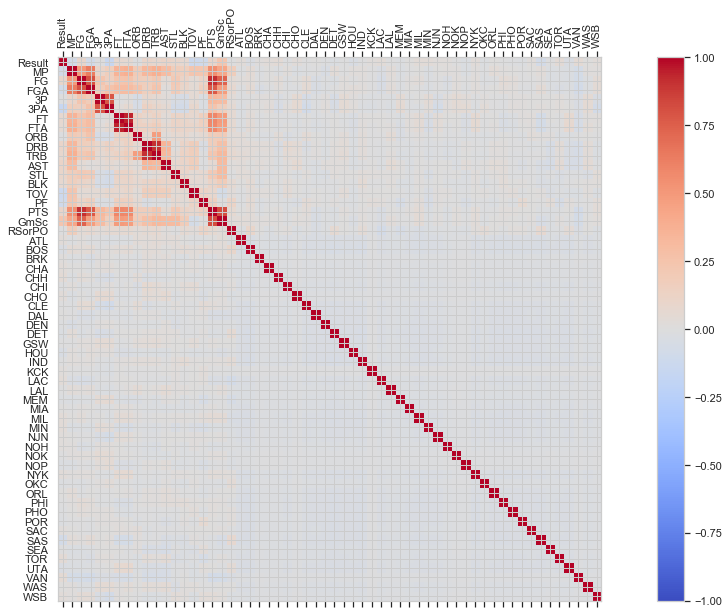

In [654]:
# all players corrolations
corr_function(allgames_stats)

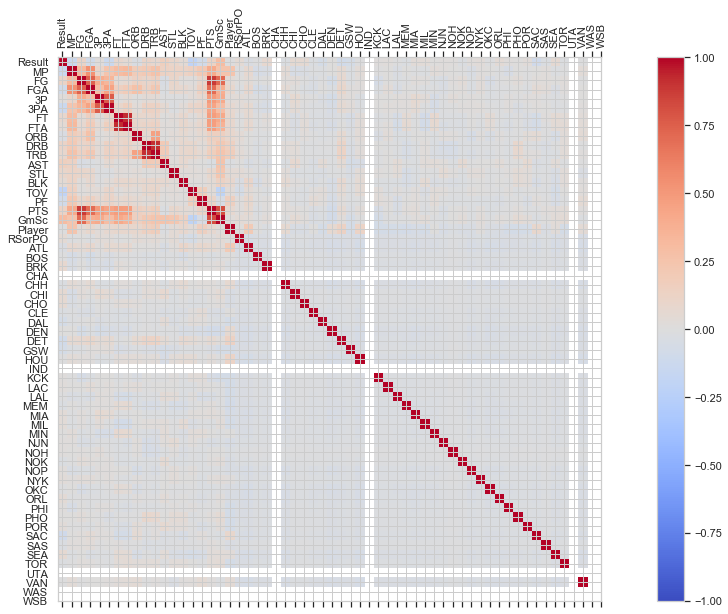

In [655]:
# labron james feature corrolations
corr_function(labron_points_stats)

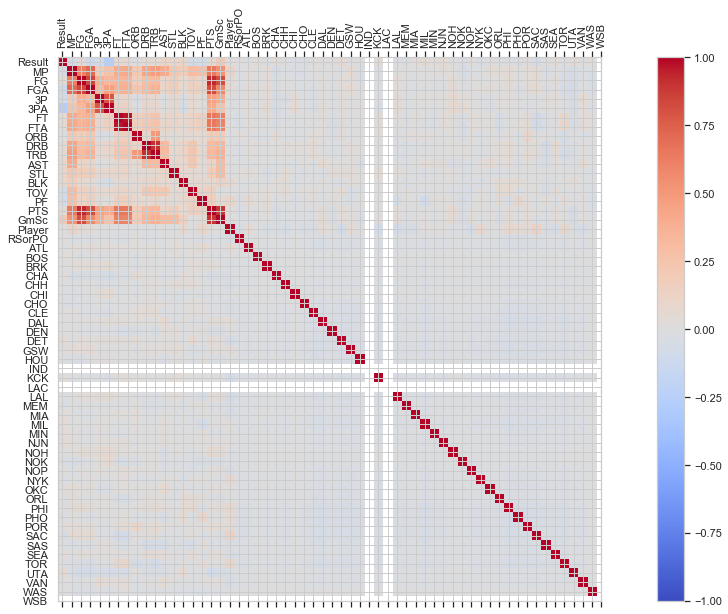

In [656]:
# Kobe feature corrolations
corr_function(kobe_points_stats)

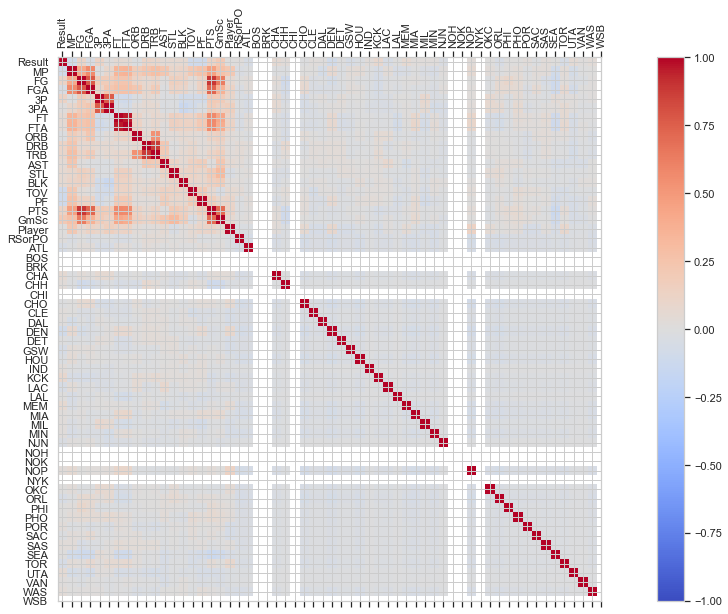

In [657]:
#  james feature corrolations
corr_function(michael_points_stats)

# Classification modules sklearn
* Linear Classifiers: 
    * Logistic Regression
    * Naive Bayes Classifier
* K Nearest Neighbor ( k=3 )
* Support Vector Machines
* Decision Trees
* Boosted Trees
* Random Forest

# Part 1: Simple modules sklearn


In [658]:
labron_points_stats['Result'].value_counts()

1    945
0    492
Name: Result, dtype: int64

In [659]:
kobe_points_stats['Result'].value_counts()

1    971
0    595
Name: Result, dtype: int64

In [660]:
michael_points_stats['Result'].value_counts()

1    825
0    426
Name: Result, dtype: int64

In [661]:
michael_points_stats.columns

Index([u'Result', u'MP', u'FG', u'FGA', u'3P', u'3PA', u'FT', u'FTA', u'ORB',
       u'DRB', u'TRB', u'AST', u'STL', u'BLK', u'TOV', u'PF', u'PTS', u'GmSc',
       u'Player', u'RSorPO', u'ATL', u'BOS', u'BRK', u'CHA', u'CHH', u'CHI',
       u'CHO', u'CLE', u'DAL', u'DEN', u'DET', u'GSW', u'HOU', u'IND', u'KCK',
       u'LAC', u'LAL', u'MEM', u'MIA', u'MIL', u'MIN', u'NJN', u'NOH', u'NOK',
       u'NOP', u'NYK', u'OKC', u'ORL', u'PHI', u'PHO', u'POR', u'SAC', u'SAS',
       u'SEA', u'TOR', u'UTA', u'VAN', u'WAS', u'WSB'],
      dtype='object')

In [662]:
cols=['MP','FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','GmSc','RSorPO','ATL','BOS','BRK','CHA','CHH','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','KCK','LAC','LAL','MEM','MIA','MIL','MIN','NJN','NOH','NOK','NOP','NYK','OKC','ORL','PHI','PHO','POR','SAC','SAS','SEA','TOR','UTA','VAN','WAS','WSB'] 
labron_X = labron_points_stats[cols].fillna(0)
labron_y = labron_points_stats['Result']

kobe_X = kobe_points_stats[cols].fillna(0)
kobe_y = kobe_points_stats['Result']

jordan_X = michael_points_stats[cols].fillna(0)
jordan_y = michael_points_stats['Result']

lab_X_train, lab_X_test, lab_y_train, lab_y_test = train_test_split(labron_X, labron_y, test_size=0.3, random_state=0)
kobe_X_train, kobe_X_test, kobe_y_train, kobe_y_test = train_test_split(kobe_X, kobe_y, test_size=0.3, random_state=0)
jord_X_train, jord_X_test, jord_y_train, jord_y_test = train_test_split(jordan_X, jordan_y, test_size=0.3, random_state=0)

In [663]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Logistic Regression


In [664]:

logreg_lab = LogisticRegression()
logreg_lab.fit(lab_X_train, lab_y_train)

logreg_kobe = LogisticRegression()
logreg_kobe.fit(kobe_X_train, kobe_y_train)

logreg_jord = LogisticRegression()
logreg_jord.fit(jord_X_train, jord_y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Labron: Confussion Matrix: Logistic Regression

In [665]:
conf_matrix(logreg_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.72
[[ 76  72]
 [ 49 235]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=75	|   FP=73	|
|   **Actual Pos**	|   FN=48	|   TP=236	|

In [666]:
#roc_graph(logreg_lab,lab_X_test,lab_y_test)

#### Kobe: Confussion Matrix: Logistic Regression

In [667]:
conf_matrix(logreg_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.71
[[ 95  76]
 [ 60 239]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=125	|   FP=46	|
|   **Actual Pos**	|   FN=111	|   TP=188	|

In [668]:
#roc_graph(logreg_kobe,kobe_X_test,kobe_y_test)

#### Labron james: Confussion Matrix: Logistic Regression

In [669]:
conf_matrix(logreg_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.66
[[ 39  99]
 [ 29 209]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=36	|   FP=102	|
|   **Actual Pos**	|   FN=25	|   TP=213	|

#### ROC comperation

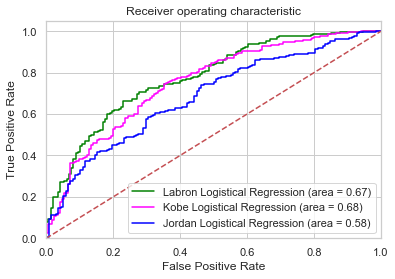

In [670]:
roc_graph(logreg_lab,lab_X_test,lab_y_test,logreg_kobe,kobe_X_test,kobe_y_test,logreg_jord,jord_X_test,jord_y_test,'Logistical Regression')

# Naive Bayes Classifier

In [671]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

gnb_lab = GaussianNB()
gnb_lab.fit(lab_X_train, lab_y_train)

gnb_kobe = GaussianNB()
gnb_kobe.fit(kobe_X_train, kobe_y_train)

gnb_jord = GaussianNB()
gnb_jord.fit(jord_X_train, jord_y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

#### Labron: Confussion Matrix: Naive Bayes

In [672]:
conf_matrix(gnb_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.45
[[115  33]
 [206  78]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=113	|   FP=35	|
|   **Actual Pos**	|   FN=200	|   TP=84	|

In [673]:
#roc_graph(logreg_lab,lab_X_test,lab_y_test)

#### Kobe: Confussion Matrix: Naive Bayes

In [674]:
conf_matrix(gnb_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.41
[[163   8]
 [267  32]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=142	|   FP=29	|
|   **Actual Pos**	|   FN=218	|   TP=81	|

In [675]:
#roc_graph(logreg_kobe,kobe_X_test,kobe_y_test)

#### Labron james: Confussion Matrix: Naive Bayes

In [676]:
conf_matrix(gnb_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.41
[[114  24]
 [196  42]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=103	|   FP=35	|
|   **Actual Pos**	|   FN=180	|   TP=58	|

#### ROC comperation

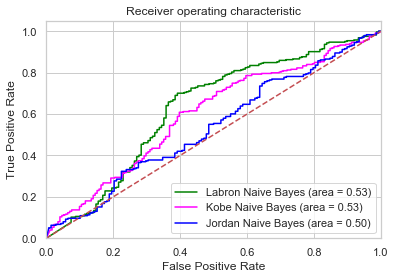

In [677]:
roc_graph(gnb_lab,lab_X_test,lab_y_test,gnb_kobe,kobe_X_test,kobe_y_test,gnb_jord,jord_X_test,jord_y_test,'Naive Bayes')

# KNN Classifier

In [678]:
from sklearn.neighbors import KNeighborsClassifier

knn_lab = KNeighborsClassifier(n_neighbors=3)
knn_lab.fit(lab_X_train, lab_y_train)

knn_kobe = KNeighborsClassifier(n_neighbors=3)
knn_kobe.fit(kobe_X_train, kobe_y_train)

knn_jord = KNeighborsClassifier(n_neighbors=3)
knn_jord.fit(jord_X_train, jord_y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

#### Labron: Confussion Matrix: Logistic Regression

In [679]:
conf_matrix(knn_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.67
[[ 68  80]
 [ 63 221]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=71	|   FP=77	|
|   **Actual Pos**	|   FN=65	|   TP=219	|

In [680]:
#roc_graph(logreg_lab,lab_X_test,lab_y_test)

#### Kobe: Confussion Matrix: Logistic Regression

In [681]:
conf_matrix(knn_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.62
[[ 76  95]
 [ 82 217]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=81	|   FP=90	|
|   **Actual Pos**	|   FN=106	|   TP=193	|

In [682]:
#roc_graph(logreg_kobe,kobe_X_test,kobe_y_test)

#### Labron james: Confussion Matrix: Logistic Regression

In [683]:
conf_matrix(knn_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.64
[[ 46  92]
 [ 44 194]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=55	|   FP=83	|
|   **Actual Pos**	|   FN=61	|   TP=177	|

#### ROC comperation

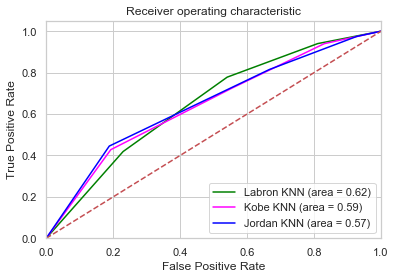

In [684]:
roc_graph(knn_lab,lab_X_test,lab_y_test,knn_kobe,kobe_X_test,kobe_y_test,knn_jord,jord_X_test,jord_y_test,'KNN')

# SVM Classifier

In [685]:
from sklearn.svm import SVC

svm_lab = SVC(kernel='linear',probability=True)
svm_lab.fit(lab_X_train, lab_y_train)

svm_kobe = SVC(kernel='linear',probability=True)
svm_kobe.fit(kobe_X_train, kobe_y_train)

svm_jord = SVC(kernel='linear',probability=True)
svm_jord.fit(jord_X_train, jord_y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Labron: Confussion Matrix: Logistic Regression

In [686]:
conf_matrix(svm_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.74
[[ 76  72]
 [ 41 243]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=77	|   FP=71	|
|   **Actual Pos**	|   FN=44	|   TP=240	|

In [687]:
#roc_graph(logreg_lab,lab_X_test,lab_y_test)

#### Kobe: Confussion Matrix: Logistic Regression

In [688]:
conf_matrix(svm_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.71
[[ 93  78]
 [ 57 242]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=127	|   FP=44	|
|   **Actual Pos**	|   FN=115	|   TP=184	|

In [689]:
#roc_graph(logreg_kobe,kobe_X_test,kobe_y_test)

#### Labron james: Confussion Matrix: Logistic Regression

In [690]:
conf_matrix(svm_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.65
[[ 37 101]
 [ 29 209]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=35	|   FP=103	|
|   **Actual Pos**	|   FN=27	|   TP=211	|

#### ROC comperation

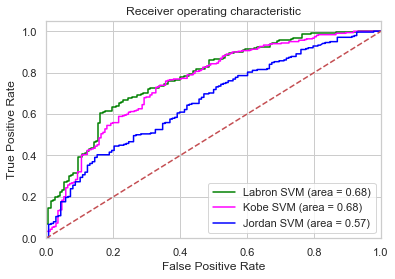

In [691]:
roc_graph(svm_lab,lab_X_test,lab_y_test,svm_kobe,kobe_X_test,kobe_y_test,svm_jord,jord_X_test,jord_y_test,'SVM')

# Decision Trees Classifier

In [692]:
from sklearn import tree

tree_lab = tree.DecisionTreeClassifier()
tree_lab.fit(lab_X_train, lab_y_train)

tree_kobe = tree.DecisionTreeClassifier()
tree_kobe.fit(kobe_X_train, kobe_y_train)

tree_jord = tree.DecisionTreeClassifier()
tree_jord.fit(jord_X_train, jord_y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Labron: Confussion Matrix: Logistic Regression

In [693]:
conf_matrix(tree_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.65
[[ 69  79]
 [ 71 213]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=68	|   FP=80	|
|   **Actual Pos**	|   FN=73	|   TP=211	|

#### Kobe: Confussion Matrix: Logistic Regression

In [694]:
conf_matrix(tree_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.65
[[ 94  77]
 [ 88 211]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=96	|   FP=75	|
|   **Actual Pos**	|   FN=116	|   TP=183	|

#### Labron james: Confussion Matrix: Logistic Regression

In [695]:
conf_matrix(tree_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.61
[[ 60  78]
 [ 70 168]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=52	|   FP=86	|
|   **Actual Pos**	|   FN=54	|   TP=184	|

#### ROC comperation

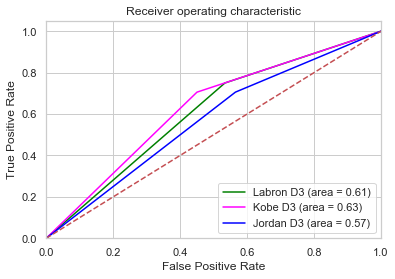

In [696]:
roc_graph(tree_lab,lab_X_test,lab_y_test,tree_kobe,kobe_X_test,kobe_y_test,tree_jord,jord_X_test,jord_y_test,'D3')

# Random Forest Classifier

In [697]:
from sklearn.ensemble import RandomForestClassifier

rf_lab = RandomForestClassifier(n_estimators=100)
rf_lab.fit(lab_X_train, lab_y_train)

rf_kobe = RandomForestClassifier(n_estimators=100)
rf_kobe.fit(kobe_X_train, kobe_y_train)

rf_jord = RandomForestClassifier(n_estimators=100)
rf_jord.fit(jord_X_train, jord_y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Labron: Confussion Matrix: Logistic Regression

In [698]:
conf_matrix(rf_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.72
[[ 67  81]
 [ 38 246]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=68	|   FP=80	|
|   **Actual Pos**	|   FN=73	|   TP=211	|

#### Kobe: Confussion Matrix: Logistic Regression

In [699]:
conf_matrix(rf_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.71
[[ 89  82]
 [ 54 245]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=96	|   FP=75	|
|   **Actual Pos**	|   FN=116	|   TP=183	|

#### Labron james: Confussion Matrix: Logistic Regression

In [700]:
conf_matrix(rf_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.66
[[ 31 107]
 [ 19 219]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=52	|   FP=86	|
|   **Actual Pos**	|   FN=54	|   TP=184	|

#### ROC comperation

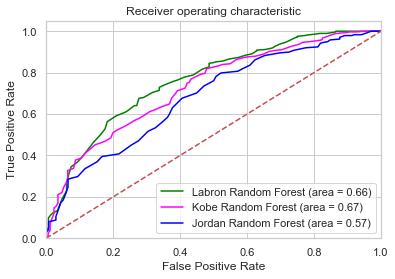

In [701]:
roc_graph(rf_lab,lab_X_test,lab_y_test,rf_kobe,kobe_X_test,kobe_y_test,rf_jord,jord_X_test,jord_y_test,'Random Forest')

# Boosted Trees Classifier

In [702]:
from sklearn.ensemble import AdaBoostClassifier

lab_X_train, lab_X_test, lab_y_train, lab_y_test = train_test_split(labron_X, labron_y, test_size=0.3, random_state=0)
kobe_X_train, kobe_X_test, kobe_y_train, kobe_y_test = train_test_split(kobe_X, kobe_y, test_size=0.3, random_state=0)
jord_X_train, jord_X_test, jord_y_train, jord_y_test = train_test_split(jordan_X, jordan_y, test_size=0.3, random_state=0)

ab_lab = RandomForestClassifier(n_estimators=100)
ab_lab.fit(lab_X_train, lab_y_train)

ab_kobe = RandomForestClassifier(n_estimators=100)
ab_kobe.fit(kobe_X_train, kobe_y_train)

ab_jord = RandomForestClassifier(n_estimators=100)
ab_jord.fit(jord_X_train, jord_y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Labron: Confussion Matrix: Logistic Regression

In [703]:
conf_matrix(ab_lab,lab_X_test,lab_y_test)

Accuracy of logistic regression classifier on test set: 0.74
[[ 67  81]
 [ 31 253]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=68	|   FP=80	|
|   **Actual Pos**	|   FN=73	|   TP=211	|

#### Kobe: Confussion Matrix: Logistic Regression

In [704]:
conf_matrix(ab_kobe,kobe_X_test,kobe_y_test)

Accuracy of logistic regression classifier on test set: 0.68
[[ 78  93]
 [ 58 241]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=96	|   FP=75	|
|   **Actual Pos**	|   FN=116	|   TP=183	|

#### Labron james: Confussion Matrix: Logistic Regression

In [705]:
conf_matrix(ab_jord,jord_X_test,jord_y_test)

Accuracy of logistic regression classifier on test set: 0.67
[[ 32 106]
 [ 17 221]]


|   Actual\Predicted	        |   Predicted Neg	|  Predicted Pos 	|
|:---:	        |:---:	|:---:	|
|  **Actual Neg**	|   TN=52	|   FP=86	|
|   **Actual Pos**	|   FN=54	|   TP=184	|

#### ROC comperation

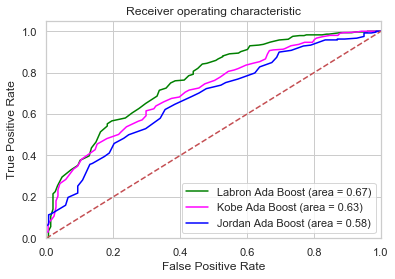

In [706]:
roc_graph(ab_lab,lab_X_test,lab_y_test,ab_kobe,kobe_X_test,kobe_y_test,ab_jord,jord_X_test,jord_y_test,'Ada Boost')

# Vote for best simple model for each player

## Labron best classifier:

In [707]:
from sklearn import model_selection

labels = ['Logistic Regression','Naive Bayes','K Nearest Neighbor','SVM','D3','Random Forest','AdaBoostClassifier']

for clf, label in zip([logreg_lab, gnb_lab, knn_lab, svm_lab, tree_lab, rf_lab, ab_lab], labels):

    scores = model_selection.cross_val_score(clf, lab_X_test, lab_y_test, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Accuracy: 0.72 (+/- 0.05) [Logistic Regression]
Accuracy: 0.43 (+/- 0.04) [Naive Bayes]
Accuracy: 0.65 (+/- 0.03) [K Nearest Neighbor]
Accuracy: 0.72 (+/- 0.05) [SVM]
Accuracy: 0.62 (+/- 0.05) [D3]
Accuracy: 0.69 (+/- 0.06) [Random Forest]
Accuracy: 0.68 (+/- 0.04) [AdaBoostClassifier]


## Kobe best classifier:

In [708]:
labels = ['Logistic Regression','Naive Bayes','K Nearest Neighbor','SVM','D3','Random Forest','AdaBoostClassifier']

for clf, label in zip([logreg_kobe, gnb_kobe, knn_kobe, svm_kobe, tree_kobe, rf_kobe, ab_kobe], labels):

    scores = model_selection.cross_val_score(clf, kobe_X_test, kobe_y_test, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Accuracy: 0.70 (+/- 0.06) [Logistic Regression]
Accuracy: 0.45 (+/- 0.03) [Naive Bayes]
Accuracy: 0.63 (+/- 0.04) [K Nearest Neighbor]
Accuracy: 0.69 (+/- 0.06) [SVM]
Accuracy: 0.64 (+/- 0.06) [D3]
Accuracy: 0.71 (+/- 0.03) [Random Forest]
Accuracy: 0.71 (+/- 0.05) [AdaBoostClassifier]


## Jord best classifier:

In [709]:
labels = ['Logistic Regression','Naive Bayes','K Nearest Neighbor','SVM','D3','Random Forest','AdaBoostClassifier']

for clf, label in zip([logreg_jord, gnb_jord, knn_jord, svm_jord, tree_jord, rf_jord, ab_jord], labels):

    scores = model_selection.cross_val_score(clf, jord_X_test, jord_y_test, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Accuracy: 0.70 (+/- 0.03) [Logistic Regression]
Accuracy: 0.38 (+/- 0.02) [Naive Bayes]
Accuracy: 0.66 (+/- 0.01) [K Nearest Neighbor]
Accuracy: 0.70 (+/- 0.02) [SVM]
Accuracy: 0.58 (+/- 0.02) [D3]
Accuracy: 0.66 (+/- 0.04) [Random Forest]
Accuracy: 0.67 (+/- 0.05) [AdaBoostClassifier]


#### It seems that labron best is: Accuracy: 0.72 (+/- 0.04) [SVM]
#### It seems that kobe best is: Accuracy: 0.70 (+/- 0.06) [Logistic Regression]
#### It seems that jord best is: Accuracy: 0.71 (+/- 0.03) [SVM]

In [743]:
from sklearn.metrics import accuracy_score

def get_wins_score(model,X_test):
    y_pred = model.predict(X_test)

    return np.count_nonzero(y_pred)
    

labron_vs_labron = (get_wins_score(svm_lab,labron_X) * 0.72)
labron_vs_kobe   = (get_wins_score(svm_lab,kobe_X) * 0.72)
labron_vs_jordan = (get_wins_score(svm_lab,jordan_X) * 0.72)

kobe_vs_kobe = (get_wins_score(svm_lab,kobe_X) * 0.7)
kobe_vs_labron = (get_wins_score(svm_lab,labron_X) * 0.7)
kobe_vs_jordan = (get_wins_score(svm_lab,jordan_X) * 0.7)

jordan_vs_jordan = (get_wins_score(svm_lab,labron_X) * 0.71)
jordan_vs_labron = (get_wins_score(svm_lab,jordan_X) * 0.71)
jordan_vs_kobe = (get_wins_score(svm_lab,kobe_X) * 0.71)

In [748]:
np.array([[labron_vs_labron,labron_vs_kobe,labron_vs_jordan],
 [kobe_vs_labron,kobe_vs_kobe,kobe_vs_jordan],
 [jordan_vs_labron,jordan_vs_kobe,jordan_vs_jordan]])

array([[749.52, 582.48, 752.4 ],
       [728.7 , 566.3 , 731.5 ],
       [741.95, 574.39, 739.11]])

In [747]:
print ("labron_vs_labron: %.2f" % score_arr[1])
print ("labron_vs_kobe: %.2f" % score_arr[2])
print ("labron_vs_jordan: %.2f" % score_arr[3])

print ("kobe_vs_labron: %.2f" % score_arr[4].astype(float))
print ("kobe_vs_kobe: %.2f"  % score_arr[5])
print ("kobe_vs_jordan: %.2f" % score_arr[6])

print ("labron_vs_labron: %.2f" %score_arr[7])
print ("labron_vs_kobe: %.2f"  % score_arr[8])
print ("labron_vs_jordan: %.2f" % score_arr[9])

TypeError: float argument required, not numpy.ndarray